In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#1. Dataset Preparation
print("Loading and Splitting Dataset...")
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    './data/train/',
    target_size=(128, 128),
    batch_size=32,
    subset='training'
)
val_gen = datagen.flow_from_directory(
    './data/train/',
    target_size=(128, 128),
    batch_size=32,
    subset='validation'
)


Loading and Splitting Dataset...
Found 5278 images belonging to 10 classes.
Found 1317 images belonging to 10 classes.


In [5]:
#2. Baseline CNN Model (Run 1)
print("Starting Run 1: Baseline CNN Model")
model_a = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_a = model_a.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[callback])

Starting Run 1: Baseline CNN Model
Epoch 1/15
165/165 [==============================] - 62s 371ms/step - loss: 2.2061 - accuracy: 0.2052 - val_loss: 2.0909 - val_accuracy: 0.2566
Epoch 2/15
165/165 [==============================] - 60s 362ms/step - loss: 2.0787 - accuracy: 0.2613 - val_loss: 2.0322 - val_accuracy: 0.2787
Epoch 3/15
165/165 [==============================] - 60s 362ms/step - loss: 2.0329 - accuracy: 0.2797 - val_loss: 2.0241 - val_accuracy: 0.3030
Epoch 4/15
165/165 [==============================] - 60s 363ms/step - loss: 2.0053 - accuracy: 0.3007 - val_loss: 1.9783 - val_accuracy: 0.2992
Epoch 5/15
165/165 [==============================] - 60s 361ms/step - loss: 1.9879 - accuracy: 0.2999 - val_loss: 1.9722 - val_accuracy: 0.2908
Epoch 6/15
165/165 [==============================] - 58s 350ms/step - loss: 1.9666 - accuracy: 0.3128 - val_loss: 1.9374 - val_accuracy: 0.3106
Epoch 7/15
165/165 [==============================] - 59s 357ms/step - loss: 1.9500 - accuracy:

In [6]:
# ====================================================
#3. Transfer Learning Model (Run 2)
# ====================================================

print("Starting Run 2: MobileNetV2 Transfer Learning Model")
base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
base.trainable = False  # feature extraction stage

model_b = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_b = model_b.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[callback])


🚀 Starting Run 2: MobileNetV2 Transfer Learning Model
Epoch 1/15
165/165 [==============================] - 54s 317ms/step - loss: 1.8362 - accuracy: 0.4166 - val_loss: 1.3271 - val_accuracy: 0.5596
Epoch 2/15
165/165 [==============================] - 52s 313ms/step - loss: 1.3992 - accuracy: 0.5572 - val_loss: 1.2317 - val_accuracy: 0.5847
Epoch 3/15
165/165 [==============================] - 52s 316ms/step - loss: 1.2886 - accuracy: 0.5847 - val_loss: 1.2240 - val_accuracy: 0.5953
Epoch 4/15
165/165 [==============================] - 51s 311ms/step - loss: 1.1998 - accuracy: 0.6034 - val_loss: 1.2469 - val_accuracy: 0.5854
Epoch 5/15
165/165 [==============================] - 52s 313ms/step - loss: 1.1571 - accuracy: 0.6188 - val_loss: 1.2119 - val_accuracy: 0.5877
Epoch 6/15
165/165 [==============================] - 51s 312ms/step - loss: 1.1488 - accuracy: 0.6209 - val_loss: 1.2087 - val_accuracy: 0.6090
Epoch 7/15
165/165 [==============================] - 52s 314ms/step - loss

In [7]:
#4. Evaluation Section
print("Evaluating Both Models...")
# Baseline CNN Evaluation
print("\n===== Baseline CNN Evaluation =====")
y_true = val_gen.classes
y_pred_a = np.argmax(model_a.predict(val_gen), axis=1)
print("Top-1 Accuracy:", np.mean(y_true == y_pred_a))
conf_mat_a = confusion_matrix(y_true, y_pred_a)
class_acc_a = conf_mat_a.diagonal() / conf_mat_a.sum(axis=1)
print("Average Accuracy per Class:", np.mean(class_acc_a))

# Transfer Learning Evaluation
print("\n===== MobileNetV2 Evaluation =====")
y_pred_b = np.argmax(model_b.predict(val_gen), axis=1)
print("Top-1 Accuracy:", np.mean(y_true == y_pred_b))
conf_mat_b = confusion_matrix(y_true, y_pred_b)
class_acc_b = conf_mat_b.diagonal() / conf_mat_b.sum(axis=1)
print("Average Accuracy per Class:", np.mean(class_acc_b))


📊 Evaluating Both Models...

===== Baseline CNN Evaluation =====
42/42 [==============================] - 8s 195ms/step
Top-1 Accuracy: 0.1427486712224753
Average Accuracy per Class: 0.10657096615976043

===== MobileNetV2 Evaluation =====
42/42 [==============================] - 11s 248ms/step
Top-1 Accuracy: 0.11313591495823842
Average Accuracy per Class: 0.09419626758028359


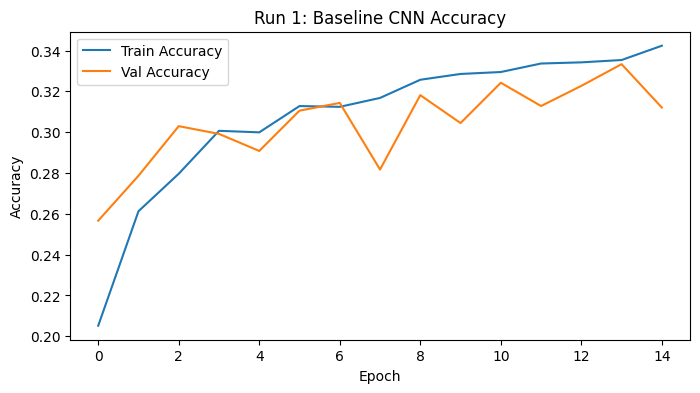

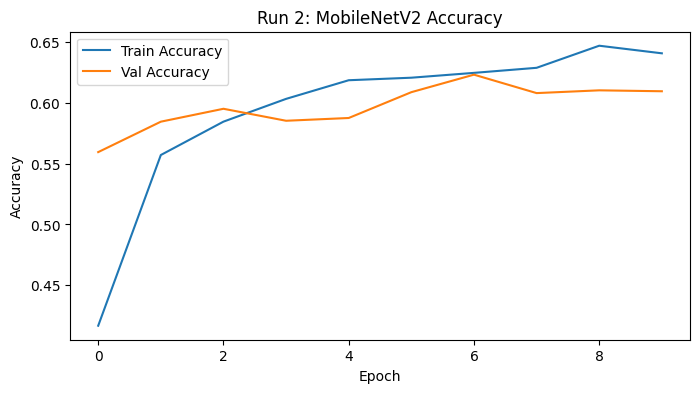


✅ All runs completed successfully!


In [8]:
#5. Visualization Section
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_a, "Run 1: Baseline CNN Accuracy")
plot_history(history_b, "Run 2: MobileNetV2 Accuracy")

print("All runs completed successfully!")